# Visualizing gpx data

## Imports

In [573]:
from math import sqrt, floor

import datetime
from math import sqrt, floor
import numpy as np
import pandas as pd
import haversine


# https://github.com/christopherbronner/gps-run-tracker/blob/master/GPS%20tracker.ipynb
import gpxpy
import gpxpy.gpx
from time import strftime
import matplotlib.pyplot as plt
import copy
from matplotlib.cm import terrain # import color map
from matplotlib.cm import cool # import color map
import ipyleaflet as lf

import geopy
from geographiclib.geodesic import Geodesic #for heading
geod = Geodesic.WGS84  # define the WGS84 ellipsoid
# from GPX_reader import GPX_interpolate as gpx_interpolate #for interpolating
import gpx_interpolate

from math import degrees, cos, sin, atan2 #for bearing calculations
from scipy.signal import find_peaks #for hairpin detection

import statistics #for standard deviation of turns
import os #to get files

from scipy.signal import savgol_filter
import seaborn as sns # seaborn for plotting

### Pull in the gps data

In [574]:
def gpxfile_to_lat_lon(path, filename):
    base=os.path.basename(path + filename)
    gpx_file = open(path + filename, 'r')
    gpx = gpxpy.parse(gpx_file)

    lat = []
    lon = []
    ele = []
    tstamp = []
    tzinfo = []

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lat.append(point.latitude)
                lon.append(point.longitude)
#                 df_newRow = pd.DataFrame([[point.time, point.latitude, point.longitude, point.elevation]], columns=['time','lat','lon','elev'])
#                 df = df.append(df_newRow, ignore_index=True)
                ele.append(point.elevation)
    return lat, lon, ele, gpx
#     files.append(filename)
#         courses.append(os.path.splitext(base)[0])

In [575]:
def gpxfile_to_gpx(path, filename):
    base=os.path.basename(path + filename)
    gpx_file = open(path + filename, 'r')
    gpx = gpxpy.parse(gpx_file)
    
    return gpx

In [576]:
def gpx_to_lat_lon(gpx):
    lat = []
    lon = []
    ele = []
    tstamp = []
    tzinfo = []

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lat.append(point.latitude)
                lon.append(point.longitude)
#                 df_newRow = pd.DataFrame([[point.time, point.latitude, point.longitude, point.elevation]], columns=['time','lat','lon','elev'])
#                 df = df.append(df_newRow, ignore_index=True)
                ele.append(point.elevation)
    return lat, lon, ele

In [577]:
# path, filename = ('/Users/jeremywalsh/OneDrive - SUEZ/Personal/XC/Race GPX/Courses/',
#  'Bayfront Park 7km.gpx')
# lat, lon = gpx_to_lat_lon(path, filename)

### Plot the gps course

In [578]:
# #fig = plt.figure(facecolor = '0.05')
# fig = plt.figure()
# ax = plt.Axes(fig, [0., 0., 1., 1.], )
# #ax.set_aspect('equal')
# ax.set_axis_off()
# fig.add_axes(ax)
# plt.plot(lon, lat, color = 'deepskyblue', lw = 0.2, alpha = 0.8)
# plt.show()

### Interpolate to get more data points

In [579]:
# res = 1 #one point every meter
# deg = 2

# gpx_data = {'lat':lat,
#             'lon':lon,
#             'ele':elev,
#             'tstamp':None,
#             'tzinfo':None}

# gpx_data_interp = gpx_interpolate(gpx_data, res, deg)

In [580]:
# def gpx_interpolate(lat, lon, filename):
#     res = 1 #one point every meter
#     deg = 2

#     gpx_data = {'lat':lat,
#                 'lon':lon,
#                 'ele':elev,
#                 'tstamp':None,
#                 'tzinfo':None}

#     gpx_data_interp = gpx_interpolate(gpx_data, res, deg)

#     fig = plt.figure(figsize=(40,20))
#     plt.scatter(gpx_data_interp['lon'], gpx_data_interp['lat'], s=1)
#     plt.scatter(lon, lat)
#     plt.show()
#     fig.savefig(filename)
    
#     return gpx_interpolate

In [581]:
# gpx_interpolate(lat, lon, filename)

## Get the heading

In [582]:
# Geodesic.WGS84.Inverse(-41.32, 174.81, 40.96, -5.50)
# df[['lon', 'lat']].iloc[0][0]


def angle_diff(gpx_data_interp, window):
    bearing = []
    p2p_distance = []

    for i in range(len(gpx_data_interp['lon'])-1):
        lon1 = gpx_data_interp['lon'][i]
        lat1 = gpx_data_interp['lat'][i]
        lon2 = gpx_data_interp['lon'][i+1]
        lat2 = gpx_data_interp['lat'][i+1]

        bearing_tmp = atan2(sin(lon2-lon1)*cos(lat2), cos(lat1)*sin(lat2)-sin(lat1)*cos(lat2)*cos(lon2-lon1))
        bearing_tmp = degrees(bearing_tmp)
        bearing_tmp = (bearing_tmp + 360) % 360
        bearing.append(bearing_tmp)

    #     bearing.append(Geodesic.WGS84.Inverse(lon1, lat1, lon2, lat2)['azi1']) #degrees clockwise from north)
        p2p_distance.append(Geodesic.WGS84.Inverse(lon1, lat1, lon2, lat2)['s12']) #distance between each point in meters
    
    #smoothing the bearing since for some tracks it is messy and throws off hairpin detection
#     bearing = savgol_filter(bearing, 41, 2) # window size 51, polynomial order 2
    
    # bearing.insert(0, np.nan) #making the same length as df
    p2p_distance.insert(0, 0) #making the same length as df
    p2p_distance = np.cumsum(p2p_distance)


    bearing_diff = [bearing[i + 1] - bearing[i] for i in range(len(bearing)-1)]
    angle_diff = [(bearing_diff[i] + 180) % 360 - 180 for i in range(len(bearing)-1)]

    angle_df = pd.DataFrame(angle_diff).rolling(window=window, center=True).sum()
    angle_df = angle_df.abs() # taking the absolute value so we get all the peask

    angle_df.loc[-1] = [np.nan]
    angle_df.loc[-2] = [np.nan]

    angle_df.index = angle_df.index + 3  # shifting index
    angle_df.sort_index(inplace=True) 

    df = pd.DataFrame({'lat':gpx_data_interp['lat'],'lon':gpx_data_interp['lon'], 'angle_diff':angle_df[0]})
    return df, bearing

In [583]:
# window = 40 #meters long to consider a hairpin turn complete
# df, bearing = angle_diff(gpx_data_interp,window)

## Hairpin turn detection via bearing angle difference peak detection

In [584]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
output_notebook()

Loading BokehJS ...

In [83]:
def hairpin_detection(df, height, bearing, gpx_data_interp, course):
    peaks, _ = find_peaks(df['angle_diff'], height=height, prominence=50)
    print('Number of hairpins in course')
    print(len(peaks))
    
#     plot it
    fig = plt.figure(figsize=(20,8))
    plt.rcParams.update({'font.size': 22})
    plt.plot(df['angle_diff'])
    plt.plot(bearing)
    
    plt.scatter(peaks, df['angle_diff'].iloc[peaks])
    plt.title('Bearing and Bearing Changes - ' + str(course))
    plt.show()
    
#     #plot them on the course
#     fig = plt.figure(figsize=(10,10))
#     plt.rcParams.update({'font.size': 30})
#     plt.scatter(gpx_data_interp['lon'], gpx_data_interp['lat'], s=5)
#     plt.scatter(df['lon'].iloc[peaks], df['lat'].iloc[peaks], s=100)
#     plt.title('Course Map with Hairpins - ' + str(course))
#     plt.show()
    
    # bokeh
    # Create the figure: p
    p = figure(title='Course Map with Hairpins - ' + str(course), x_axis_label='lon', y_axis_label='lat', plot_width=500, plot_height=500)
    # Add a circle glyph to the figure p
    p.circle(gpx_data_interp['lon'], gpx_data_interp['lat'], size = 0.5)
    p.circle(df['lon'].iloc[peaks], df['lat'].iloc[peaks], color='red', size = 10, alpha=0.8)
    # Display the plot
    show(p)
    
    
    print('Standard Deviation')
    st_dev = statistics.stdev(df['angle_diff'].dropna())
    print(st_dev)
    print('Total Degrees Turned')
    tot_deg_turned = sum([abs(ele) for ele in df['angle_diff'].dropna()])
    print(tot_deg_turned)
    
    return st_dev, tot_deg_turned, len(peaks)

In [412]:
def add_distance(gpx, df):
    alt_dif = [0]
    time_dif = [0]
    dist_vin = [0]
    dist_hav = [0]
    dist_vin_no_alt = [0]
    dist_hav_no_alt = [0]
    dist_dif_hav_2d = [0]
    dist_dif_vin_2d = [0]

    
    data = gpx.tracks[0].segments[0].points
    for index in range(len(data)):
        if index == 0:
            pass
        else:
            start = data[index-1]

            stop = data[index]

            distance_vin_2d = geopy.distance.geodesic((start.latitude, start.longitude), (stop.latitude, stop.longitude)).m
            dist_dif_vin_2d.append(distance_vin_2d)

            distance_hav_2d = haversine.haversine((start.latitude, start.longitude), (stop.latitude, stop.longitude))*1000

            dist_dif_hav_2d.append(distance_hav_2d)

            dist_vin_no_alt.append(dist_vin_no_alt[-1] + distance_vin_2d)

            dist_hav_no_alt.append(dist_hav_no_alt[-1] + distance_hav_2d)

            alt_d = start.elevation - stop.elevation

            alt_dif.append(alt_d)

            distance_vin_3d = sqrt(distance_vin_2d**2 + (alt_d)**2)

            distance_hav_3d = sqrt(distance_hav_2d**2 + (alt_d)**2)

            try:
                time_delta = (stop.time - start.time).total_seconds()
            except:
                #no time in data
                time_delta = 0

            time_dif.append(time_delta)

            dist_vin.append(dist_vin[-1] + distance_vin_3d)

            dist_hav.append(dist_hav[-1] + distance_hav_3d)

    df1 = pd.DataFrame()
    df1['dis_vin_2d'] = dist_vin_no_alt 
    df1['dist_hav_2d'] = dist_hav_no_alt
    df1['dis_vin_3d'] = dist_vin
    df1['dis_hav_3d'] = dist_hav
    df1['alt_dif'] = alt_dif
    df1['time_dif'] = time_dif
    df1['dis_dif_hav_2d'] = dist_dif_hav_2d
    df1['dis_dif_vin_2d'] = dist_dif_vin_2d

#     print('Vincenty 2D : ', dist_vin_no_alt[-1])
#     print('Haversine 2D : ', dist_hav_no_alt[-1])
    print('Vincenty 3D : ', dist_vin[-1])
#     print('Haversine 3D : ', dist_hav[-1])
    print('Total Time : ', floor(sum(time_dif)/60),' min ', int(sum(time_dif)%60),' sec ')
    
    df = pd.concat([df, df1], axis=1)
    
    return df

In [344]:
from scipy.signal import argrelextrema

def plot_ele_max_min(df):
    # Plot results
    fig = plt.figure(figsize=(20,8))
    plt.scatter(df['dis_hav_3d'], df['min'], c='r')
    plt.scatter(df['dis_hav_3d'], df['max'], c='g')
    plt.plot(df['dis_hav_3d'], df['Elevation'])
    plt.show()

In [277]:
# height = 140 #number of degrees in a hairpin turn over the window length
# hairpin_detection(df, height, bearing, gpx_data_interp)

## Calculate Course Area
Look at the total area the course covers as a comparison for how turny the course is. ie how good is the course/race director at minimizing turns (if that was a desired goal).

In [278]:
def course_area(geod, df):
    p = geod.Polygon()
    for pnt in range(len(df)):
        if pnt == 0:
            continue
        p.AddPoint(df['lat'][pnt], df['lon'][pnt])

    num, perim, area = p.Compute()
    print("Race Distance/area of the course are {:.3f} m / {:.1f} m^2".format(perim, area))
    return perim, area

In [343]:
# df

In [349]:
def hills(df):
    n=20 # number of points to be checked before and after 
    # Find local peaks
    df['min'] = df.iloc[argrelextrema(df['Elevation'].values, np.less_equal, order=n)[0]]['Elevation']
    df['max'] = df.iloc[argrelextrema(df['Elevation'].values, np.greater_equal, order=n)[0]]['Elevation']

    max_locs = df['max'].index.get_indexer(df['max'].index[~df['max'].isnull()]) #index locations of the max's
    min_locs = df['min'].index.get_indexer(df['min'].index[~df['min'].isnull()]) #index locations of the min's

    #min locs remove duplicates
    for i in range(len(min_locs)):
        if i == len(min_locs)-1: #skip the last one
            continue
        else:
            if min_locs[i] == min_locs[i+1]-1: #check if it is the same as the previous one
                df['min'][min_locs[i]] = np.nan #setting it to nan so we don't have duplicates

    min_locs = df['min'].index.get_indexer(df['min'].index[~df['min'].isnull()])

    #max locs remove duplicates
    for i in range(len(max_locs)):
        if i == len(max_locs)-1: #skip the last one
            continue
        else:
            if max_locs[i] == max_locs[i+1]-1: #check if it is the same as the previous one
                df['max'][max_locs[i]] = np.nan #setting it to nan so we don't have duplicates

    max_locs = df['max'].index.get_indexer(df['max'].index[~df['max'].isnull()])
    
    # get the hill climbs
    min_vals = []
    max_vals = []
    hill_climbs = []
    hill_lengths = []

    for i in range(len(max_locs)): #loop through each max location
        if i == len(max_locs)-1: #skip the last one to avoid out of range error b/c zero index
            continue
        else:
            min_val = df['min'][min_locs[i]] #get this hill's min elevation
            max_val = df['max'][max_locs[i]] #get this hill's max elevation
            hill_climb = max_val - min_val #get the hill climb amount

            hill_start = df['dis_hav_3d'][min_locs[i]] #get this hill's start point
            hill_end = df['dis_hav_3d'][max_locs[i]] #get this hill's end point
            hill_length = hill_end - hill_start

            min_vals.append(min_val)
            max_vals.append(max_val)
            hill_climbs.append(hill_climb)
            hill_lengths.append(hill_length)
            
    plot_ele_max_min(df)
        
    return min_vals, max_vals, hill_climbs, hill_lengths, df

In [518]:
def hill_details(df, peaks, mins):
#     min_locs = df['min'].index.get_indexer(df['min'].index[~df['min'].isnull()])
#     max_locs = df['max'].index.get_indexer(df['max'].index[~df['max'].isnull()])
    
    #if the first point is a peak then set the start as the min
    if len(peaks)>0 and peaks[0]<mins[0]:
        mins = np.insert(mins, 0, 0)
        
    
    # get the hill climbs
    min_vals = []
    max_vals = []
    hill_climbs = []
    hill_lengths = []

    for i in range(len(peaks)): #loop through each max location
        try: #error handling for weird numbered hills
            min_val = df['Elevation'].iloc[mins[i]] #get this hill's min elevation
            max_val = df['Elevation'].iloc[peaks[i]] #get this hill's max elevation
            hill_climb = max_val - min_val #get the hill climb amount

            hill_start = df.index[mins[i]] #get this hill's start point
            hill_end = df.index[peaks[i]] #get this hill's end point
            hill_length = hill_end - hill_start

            min_vals.append(min_val)
            max_vals.append(max_val)
            hill_climbs.append(hill_climb)
            hill_lengths.append(hill_length)
        except:
            print('one hill error')
        
    return min_vals, max_vals, hill_climbs, hill_lengths

In [493]:
peaks

array([ 196,  399,  468,  765,  837, 1151, 1226, 1532, 1604])

In [487]:
def positive_only(x):
    if x > 0:
        return x
    else:
        return 0
    
def myround(x, prec=1, base=0.5):
    return round(base * round(float(x)/base),prec)

In [563]:
def hills_peaks(df, prominence, distance, course):
    peaks, _ = find_peaks(df['Elevation'], prominence=prominence, distance=distance)
    mins, _ = find_peaks(-df['Elevation'], prominence=prominence, distance=distance)
    print('Number of hills  in course')
    print(len(peaks))
    
#     plot it
    fig = plt.figure(figsize=(20,8))
    plt.rcParams.update({'font.size': 22})
    plt.plot(df['Elevation'])
    plt.scatter(df.index[peaks], df['Elevation'].iloc[peaks], color='red')
    plt.scatter(df.index[mins], df['Elevation'].iloc[mins], color='blue')
    plt.title('Elevationa and Peaks - ' + str(course))
    plt.show()
    
    #plot them on the course
    # bokeh
    p = figure(title='Course Map with Hill Peaks - ' + str(course), x_axis_label='lon', y_axis_label='lat', plot_width=500, plot_height=500)
    # Add a circle glyph to the figure p
    p.circle(df['Lon'], df['Lat'], size = 0.5)
    p.circle(df['Lon'].iloc[peaks], df['Lat'].iloc[peaks], color='red', size = 10, alpha=0.8)
    p.circle(df['Lon'].iloc[mins], df['Lat'].iloc[mins], color='blue', size = 10, alpha=0.8)
    # Display the plot
    show(p)
    
    
    print('Standard Deviation')
    st_dev = statistics.stdev(df['Elevation'].dropna())
    print(st_dev)
    print('Total Elevation Gain')
    
    pos_only = list(map(positive_only, df['alt_dif']))
    tot_elev_gain = sum(list(map(lambda x: myround(x, prec=1, base=0.9) , pos_only)))
    tot_elev_gain_unfiltered = sum(pos_only)
    
    return st_dev, peaks, mins, tot_elev_gain, tot_elev_gain_unfiltered

In [476]:
# df = dfs[-3]
# df

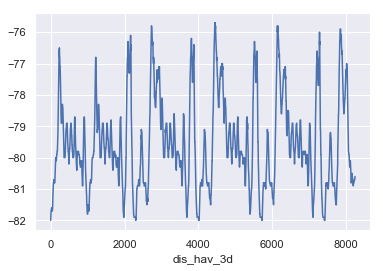

In [477]:
(-df['Elevation']).plot()

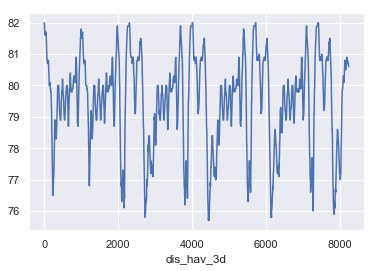

In [478]:
df['Elevation'].plot()

In [532]:

# hill_df['Hill Height'].max()
# hill_df['Hill Gradient'].max()
# len(hill_df)
hill_df

,index,Hill Height,Hill Distance,Hill Gradient
0,2,5.9,139.628187,4.225508
1,4,5.8,200.754915,2.889095
2,6,5.7,203.105922,2.806417
3,8,6.0,134.967674,4.445509


In [571]:
path = '/Users/jeremywalsh/OneDrive - SUEZ/Personal/XC/Race GPX/Courses/'
directory = os.fsencode(path)
    
courses = []
st_devs = []
tot_deg_turneds = []
perims = []
areas = []
num_hairpins = []
dfs = []
tallest_hills = []
num_hills_list = []
turn_st_devs = []
hill_st_devs = []
tot_elev_gains = []
tot_elev_gain_unfiltereds = []

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".gpx"): 
        
        print(filename)
        
        base=os.path.basename(path + filename)
        course = os.path.splitext(base)[0]
        courses.append(course)
        
        gpx_file = path + filename
        gpx_data = gpx_interpolate.gpx_read(gpx_file)
        gpx_data_interp = gpx_interpolate.gpx_interpolate(gpx_data, res=2, deg = 3)
        
        window = 20 #meters long to consider a hairpin turn complete
        df, bearing = angle_diff(gpx_data_interp, window)
        
        height = 150 #number of degrees in a hairpin turn over the window length
        turn_st_dev, tot_deg_turned, num_peak = hairpin_detection(df, height, bearing, gpx_data_interp, course)
        
        perim, area = course_area(geod, df)
        
        turn_st_devs.append(turn_st_dev)
        tot_deg_turneds.append(tot_deg_turned)
        perims.append(perim)
        areas.append(area)
        num_hairpins.append(num_peak)
        
        #get the elevation and distance
        gpx = gpxfile_to_gpx(path, filename)
        lat, lon, ele = gpx_to_lat_lon(gpx)
        df = pd.DataFrame({'Lat': lat, 'Lon': lon, 
                   'Elevation': ele})
        df = add_distance(gpx, df)
        df.set_index('dis_hav_3d', inplace=True)
         
#         course_max_min(df) #plot the course max and min
        
#         #get the hills
#         min_vals, max_vals, hill_climbs, hill_lengths, df = hills(df)
#         print('hills')
#         print(hill_climbs, hill_lengths)
        
        hill_min_height = 5
        length_of_hill = 5
        hill_st_dev, peaks, mins, tot_elev_gain, tot_elev_gain_unfiltered = hills_peaks(df, hill_min_height, length_of_hill, course)
        hill_st_devs.append(hill_st_dev)
        tot_elev_gains.append(tot_elev_gain)
        tot_elev_gain_unfiltereds.append(tot_elev_gain_unfiltered)
        
        print(df.columns)
        min_vals, max_vals, hill_climbs, hill_lengths = hill_details(df, peaks, mins)
        print('hills')
        hill_grade = np.divide(hill_climbs, hill_lengths)*100
        # put all of the hill details into a dataframe of some sort so that we can compare the different sites
        hill_df = pd.DataFrame({'Hill Height': hill_climbs, 'Hill Distance': hill_lengths, 'Hill Grade': hill_grade})
        #drop hills with too low of a grade
        hill_df.drop(hill_df[hill_df['Hill Grade'] < 1].index, inplace=True)
        hill_df.reset_index(drop=True, inplace=True)
        num_hills = len(hill_df)
        
        #list of tallest hill for each course
        tallest_hills.append(hill_df['Hill Height'].max())
        num_hills_list.append(num_hills)
        
        dfs.append(df)
        
course_info_df = pd.DataFrame({'Course': courses, 'Turn Stdev': turn_st_devs, 
                               'Total Degrees Turned': tot_deg_turneds, 'Perimeters/Total Distance': perims,
                              'Course Area': areas, 'Number of Hairpin Turns': num_hairpins, 'Hill Stdev': hill_st_devs,
                              'Tallest Hill': tallest_hills, 'Number of Hills': num_hills_list,
                              'Total Elevation Gain': tot_elev_gains, 'Total Elevation Gain Unfiltered': tot_elev_gain_unfiltereds})
course_info_df['Course Area'] = course_info_df['Course Area'].abs() #sometiems area is negative


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-571-7dfc849eb29b>", line 18, in <module>
    for file in os.listdir(directory):
FileNotFoundError: [Errno 2] No such file or directory: b'/Users/jeremywalsh/OneDrive - SUEZ/Personal/XC/Race GPX/Courses/'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2018, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1095, in 

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/jeremywalsh/OneDrive - SUEZ/Personal/XC/Race GPX/Courses/'

In [568]:
course_info_df

,Course,Turn Stdev,Total Degrees Turned,Perimeters/Total Distance,Course Area,Number of Hairpin Turns,Hill Stdev,Tallest Hill,Number of Hills,Total Elevation Gain,Total Elevation Gain Unfiltered
0,King City 10km,25.008020,124457.403119,10365.704055,961627.116177,1,1.014632,NaN,0,0.0,124.4
1,Western International 10km,33.539182,107063.690931,9995.069748,460585.033714,4,8.938636,28.30,9,157.5,124.4
2,Louisville Classic 8km,22.283734,65813.163739,8564.183636,644055.301738,0,2.971927,NaN,0,38.7,124.4
3,Fort Henry 10km,33.210720,121117.155584,10146.846494,325336.824553,4,1.567794,NaN,0,51.3,124.4
4,Point Pleasant Park,37.764212,149565.774571,9833.651106,229523.489920,14,8.136408,17.20,7,132.3,124.4
5,Malden Park 10km,36.009110,94586.138783,9676.018510,652511.773439,9,3.697679,5.60,1,83.7,124.4
6,Guelph Arboretum 7_5km,27.788016,81815.021690,7567.653255,524346.636078,0,4.864457,12.70,8,84.6,124.4
7,Fanshawe Invitational 8km,26.932202,82266.773585,8189.231553,609485.120894,5,2.464474,8.10,4,70.2,124.4
8,StFX Invitational 8km,62.495829,229882.170481,7877.891420,209506.497672,64,4.821614,12.70,8,78.3,124.4
9,Odell Park 7_5km,37.279748,115887.494406,8069.542451,283638.745914,6,9.938622,36.70,5,164.7,124.4


In [569]:
course_info_df.sort_values(by=['Total Elevation Gain'], ascending=False)

,Course,Turn Stdev,Total Degrees Turned,Perimeters/Total Distance,Course Area,Number of Hairpin Turns,Hill Stdev,Tallest Hill,Number of Hills,Total Elevation Gain,Total Elevation Gain Unfiltered
9,Odell Park 7_5km,37.279748,115887.494406,8069.542451,283638.745914,6,9.938622,36.70,5,164.7,124.4
1,Western International 10km,33.539182,107063.690931,9995.069748,460585.033714,4,8.938636,28.30,9,157.5,124.4
4,Point Pleasant Park,37.764212,149565.774571,9833.651106,229523.489920,14,8.136408,17.20,7,132.3,124.4
10,Guelph Arboretum 10km,21.008310,94949.706594,10158.208686,665799.101867,0,3.012351,14.50,4,129.6,124.4
13,Western International 8km,32.000057,81807.960726,8033.751573,361108.317223,4,8.304549,23.90,6,109.8,124.4
6,Guelph Arboretum 7_5km,27.788016,81815.021690,7567.653255,524346.636078,0,4.864457,12.70,8,84.6,124.4
5,Malden Park 10km,36.009110,94586.138783,9676.018510,652511.773439,9,3.697679,5.60,1,83.7,124.4
8,StFX Invitational 8km,62.495829,229882.170481,7877.891420,209506.497672,64,4.821614,12.70,8,78.3,124.4
12,Terre Haute 10km,33.560845,74719.589193,10696.042597,480729.555165,10,4.972641,14.58,6,74.7,124.4
7,Fanshawe Invitational 8km,26.932202,82266.773585,8189.231553,609485.120894,5,2.464474,8.10,4,70.2,124.4


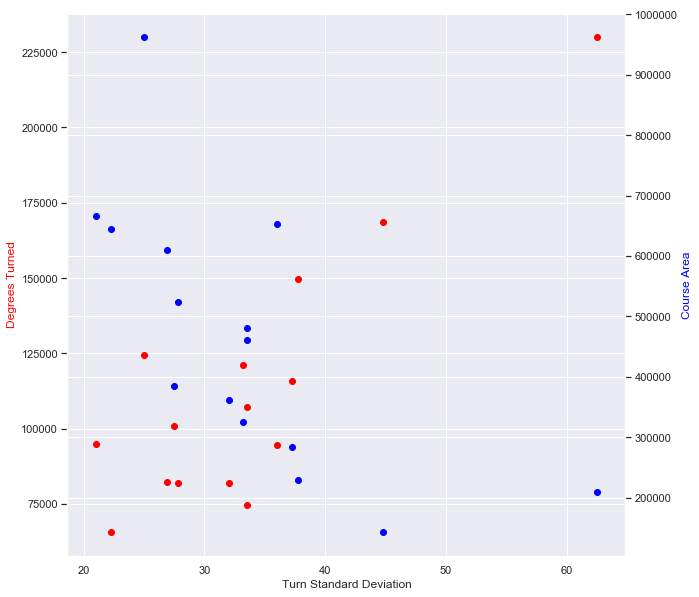

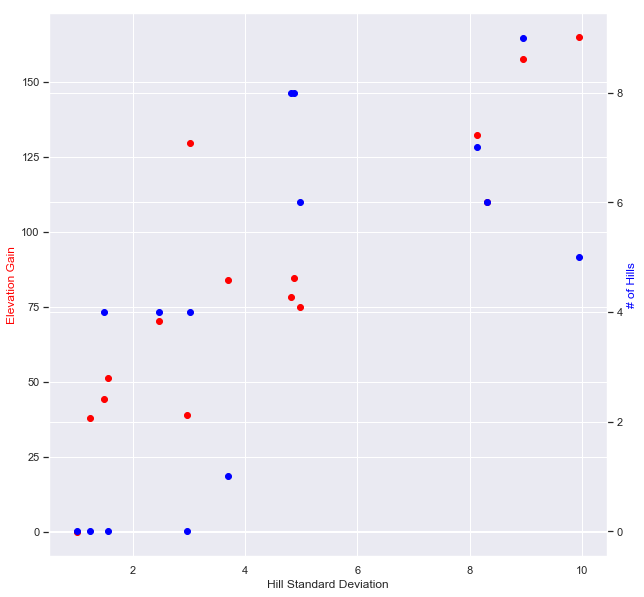

In [556]:
# Turns
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(course_info_df['Turn Stdev'], course_info_df['Total Degrees Turned'], color='red', label='Total Degrees Turned')
ax.set_ylabel('Degrees Turned', color='red')
ax.set_xlabel('Turn Standard Deviation')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.scatter(course_info_df['Turn Stdev'], course_info_df['Course Area'], color='blue', label='Course Area')
ax2.set_ylabel('Course Area', color='blue')
plt.show()

# Hills
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(course_info_df['Hill Stdev'], course_info_df['Total Elevation Gain'], color='red')
ax.set_ylabel('Elevation Gain', color='red')
ax.set_xlabel('Hill Standard Deviation')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.scatter(course_info_df['Hill Stdev'], course_info_df['Number of Hills'], color='blue')
ax2.set_ylabel('# of Hills', color='blue')
plt.show()


fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(course_info_df['Total Elevation Gain Unfiltered'], course_info_df['Total Elevation Gain'], color='red')
ax.set_ylabel('Filtered')
ax.set_xlabel('Unfiltered')
plt.show()

# drop all hills that aren't enough height over

# next step is to classify all the hills in terms of their length and height, and then filter for hills being of a certain lenght and height

In [186]:
# df['Elevation']

### Cleaning up srtm. Not helpful right now

In [155]:
!pip install SRTM.py
import srtm

    100% |████████████████████████████████| 102kB 272kB/s 
  Running setup.py bdist_wheel for SRTM.py ... done
  Stored in directory: /Users/jeremywalsh/Library/Caches/pip/wheels/ae/96/a7/f9a7a6251837678da767cf0127727c547006bcf4d577a88105
Successfully built SRTM.py


In [463]:
filename = 'King City 10km.gpx'

In [464]:
# Raw GPS.
gpx = gpxfile_to_gpx(path, filename)
lat, lon, raw_ele = gpx_to_lat_lon(gpx)

# Raw SRTM.
gpx = gpxfile_to_gpx(path, filename)
elevation_data = srtm.get_data()
elevation_data.add_elevations(gpx)
lat, lon, srtm_ele = gpx_to_lat_lon(gpx)

# Smoothed SRTM.
gpx = gpxfile_to_gpx(path, filename)
elevation_data = srtm.get_data()
elevation_data.add_elevations(gpx, smooth=True)
lat, lon, smooth_ele = gpx_to_lat_lon(gpx)

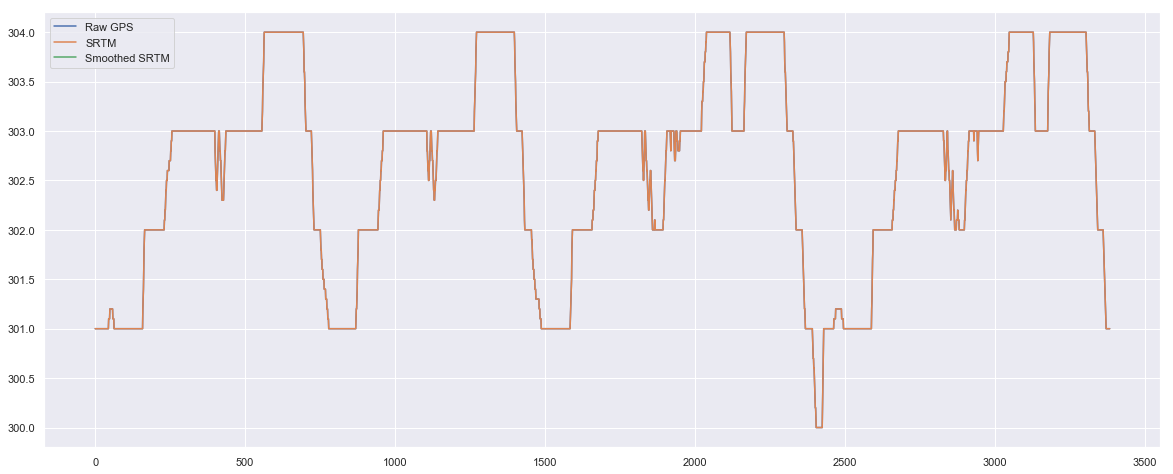

In [465]:
import seaborn

fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(raw_ele, label='Raw GPS')
ax.plot(srtm_ele, label='SRTM')
ax.plot(smooth_ele, label='Smoothed SRTM')
l = ax.legend()

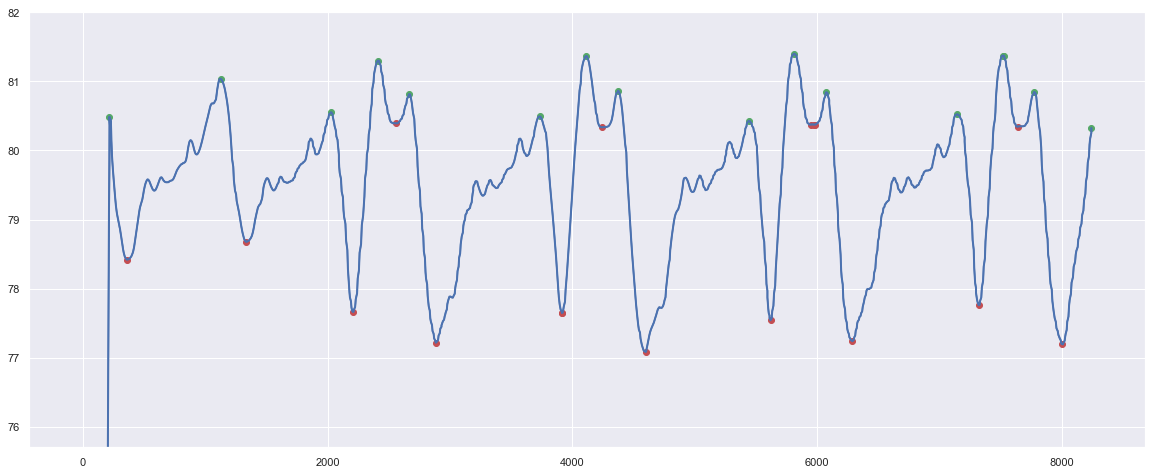

In [257]:
from scipy.signal import lfilter
from scipy.signal import savgol_filter

n = 40  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
yy = lfilter(b,a,df['Elevation'])

n=30 # number of points to be checked before and after 
# Find local peaks

df['Elevation Filtered'][n:] = yy[n:]
df['min'] = df.iloc[argrelextrema(yy, np.less_equal, order=n)[0]]['Elevation Filtered']
df['max'] = df.iloc[argrelextrema(yy, np.greater_equal, order=n)[0]]['Elevation Filtered']



fig = plt.figure(figsize=(20,8))
plt.plot(df['dis_hav_3d'], dydx, label='1st Derivative')
plt.scatter(df['dis_hav_3d'], df['min'], c='r')
plt.scatter(df['dis_hav_3d'], df['max'], c='g')
plt.plot(df['dis_hav_3d'], yy, linewidth=2, linestyle="-", c="b")  # smooth by filter
# plt.xlim(0,)
plt.ylim(df['Elevation'].min(),df['Elevation'].max())
plt.show()
# [n:]

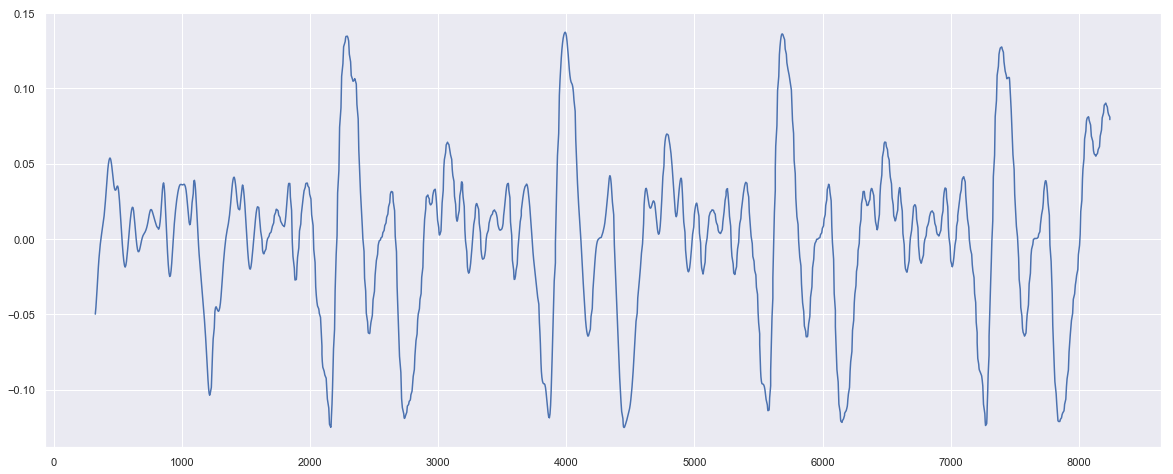

In [259]:
#deriviative approach, not that helpful
fig = plt.figure(figsize=(20,8))
dydx = savgol_filter(df['Elevation Filtered'], window_length=11, polyorder=2, deriv=1)
plt.plot(df['dis_hav_3d'][n*2:], dydx[n*2:], label='1st Derivative')
plt.show()

Using the first mininimum and the next max it sees, calculate the elevation between the two points and call this an uphill. Reverse on downhills

In [93]:
# Calculate total climb as sum of positive inclines between two waypoints
total_climb=0
for i, row in df[1:].iterrows():
    height_difference = (df.iloc[i]['Elevation'] - df.iloc[i-1]['Elevation'])
    if height_difference>0:
        total_climb += height_difference

print('Total climb: \t%.1f m' % total_climb)

Total climb: 	123.0 m


In [14]:
# courses
# st_devs
# tot_deg_turneds = []
# perims = []
# areas = []

In [15]:
df = pd.DataFrame({'Course': courses, 'Standard Deviation': st_devs, 
                   'Total Degrees Turned': tot_deg_turneds, 'Perimeter/Distance (m)': perims,
                  'Course Area (m^2)': areas, 'Number of Hairpins': num_peaks})
df['Course Area (m^2)'] = df['Course Area (m^2)'].abs()
 
df = df[~df['Course'].str.contains('StFX Invitational 8km')]

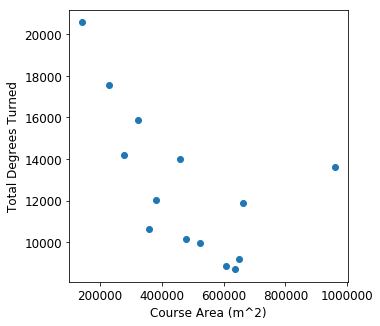

In [16]:
# df[['Total Degrees Turned', 'Course Area (m^2)']].plot()
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
plt.scatter(df['Course Area (m^2)'], df['Total Degrees Turned'])
plt.xlabel('Course Area (m^2)')
plt.ylabel('Total Degrees Turned')
# plt.scatter(df['lon'].iloc[peaks], df['lat'].iloc[peaks], s=500)
# plt.title('Course Map with Hairpins - ' + str(course))
plt.show()

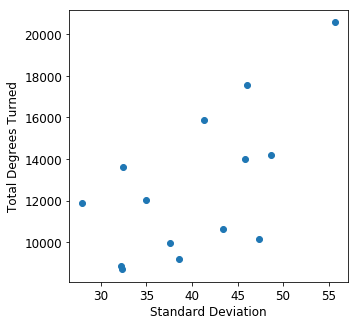

In [17]:
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
plt.scatter(df['Standard Deviation'], df['Total Degrees Turned'])
plt.xlabel('Standard Deviation')
plt.ylabel('Total Degrees Turned')
# plt.scatter(df['lon'].iloc[peaks], df['lat'].iloc[peaks], s=500)
# plt.title('Course Map with Hairpins - ' + str(course))
plt.show()

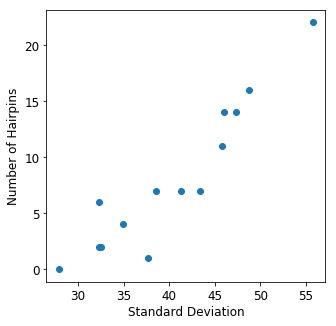

In [18]:
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
plt.scatter(df['Standard Deviation'], df['Number of Hairpins'])
plt.xlabel('Standard Deviation')
plt.ylabel('Number of Hairpins')
# plt.scatter(df['lon'].iloc[peaks], df['lat'].iloc[peaks], s=500)
# plt.title('Course Map with Hairpins - ' + str(course))
plt.show()

In [19]:
df

,Course,Standard Deviation,Total Degrees Turned,Perimeter/Distance (m),Course Area (m^2),Number of Hairpins
0,King City 10km,32.468955,13607.357039,10198.396991,961101.811871,2
1,Western International 10km,45.768951,13995.689687,9786.136422,459445.135198,11
2,Louisville Classic 8km,32.287916,8685.322190,8448.013583,638617.029917,2
3,Fort Henry 10km,41.268542,15890.025735,9949.861216,322976.416376,7
4,Point Pleasant Park,45.995413,17571.376991,9502.032720,229421.199781,14
5,Malden Park 10km,38.593744,9184.168873,9444.148256,651028.903336,7
6,Guelph Arboretum 7_5km,37.620392,9977.720123,7448.550013,522671.879840,1
7,Fanshawe Invitational 8km,32.254427,8829.590988,8047.322347,608887.510598,6
9,Odell Park 7_5km,48.721090,14200.559292,7869.776738,277620.812443,16
10,Guelph Arboretum 10km,27.916594,11906.839054,10004.123479,663328.867662,0


## To do: 
- loop through each course and build a database of the results
- add more races from accross canada (any other places i ran (other london course))
- add main ncaa races
- look most similar races
- starting point, elevation, location
- compare degrees turned with and without interpolations
- calculate how many hills in each race
- compare the biggest hills, and the steepness of hills

### Calculate the distance and total time

In [247]:
# data

In [251]:
print(len(df))
print(len(df1))

1780
1780


In [ ]:
# Loads gpx file and returns data frame run
def load_run_to_df(filename): 
    
    # Load file into run_data using gpxpy
    with open(filename) as f:
        run_data = gpxpy.parse(f)
    f.closed
    
    # Initialize DataFrames
    df_dict = {'time': [],'lat': [],'lon': [],'elev': []}
    df = pd.DataFrame(df_dict)
    
    
    # Create DataFrame containing time, latitude, longitude, elevation columns
    for track in run_data.tracks:
        for segment in track.segments:
            for point in segment.points:
                df_newRow = pd.DataFrame([[point.time, point.latitude, point.longitude, point.elevation]], columns=['time','lat','lon','elev'])
                df = df.append(df_newRow, ignore_index=True)
                
    # Create additional column for accumulative distance
    tmp = [0]
    for i, row in df[1:].iterrows():
        prevCoord = (df.iloc[i-1]['lat'],df.iloc[i-1]['lon'])
        currCoord = (df.iloc[i]['lat'],df.iloc[i]['lon'])
        tmp.append(tmp[-1] + geopy.distance.geodesic(prevCoord, currCoord).km)
    df['accuDist']=tmp
    
    return df

df = load_run_to_df(path)
df.head()

# Calculate total distance of this run
total_distance = df.iloc[-1]['accuDist']    
print('Total distance: \t%.2f km' % total_distance)

In [ ]:
# Calculate total time of this run
def strfdelta(tdelta, fmt): # Reformats timedelta object to h:mm:ss
    d = {"days": tdelta.days}
    d["hours"], rem = divmod(tdelta.seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    return fmt.format(**d)

In [ ]:
total_time = df.iloc[-1]['time']-df.iloc[0]['time'] # creates timedelta object

print('Total time: \t%s' % strfdelta(total_time, "{hours}:{minutes}:{seconds}"))

# Calculate average pace
avg_pace = total_time.seconds / total_distance
avg_pace_min, avg_pace_sec = divmod(avg_pace, 60)
print('Average pace: \t%d:%d per km' % (avg_pace_min, avg_pace_sec))

# Calculate total climb as sum of positive inclines between two waypoints
total_climb=0
for i, row in df[1:].iterrows():
    height_difference = (df.iloc[i]['elev'] - df.iloc[i-1]['elev'])
    if height_difference>0:
        total_climb += height_difference

print('Total climb: \t%.1f' % total_climb)

In [ ]:
# Plot height profile and calculate total climb
plt.plot(df['accuDist'],df['elev'], 'r')
plt.ylabel('elevation (m)')
plt.xlabel('distance (km)')
#plt.ylim(80,100)
plt.show()

# Plot height profile and calculate total climb
#fig, ax = plt.subplots()
x = df['accuDist']
y = df['elev']
plt.plot(x,y, 'b', alpha=0.5)
plt.fill_between(x, df['elev'].min(),df['elev'].max(), 'b', alpha=0.5)
plt.ylabel('elevation (m)')
plt.xlabel('distance (km)')
# plt.ylim(70,77)
plt.ylim(df['elev'].min()*0.9,df['elev'].max()*1.05)
plt.show()

In [ ]:
# Calculate current pace

# pace_hist is a list of paces between two points each
pace_hist=[]
for i, row in df[1:].iterrows():
    time_diff = df.iloc[i]['time']-df.iloc[i-1]['time']
    pos_diff  = df.iloc[i]['accuDist']-df.iloc[i-1]['accuDist']
    curr_pace = time_diff.seconds / pos_diff
    pace_hist.append(curr_pace/60)
    
# remove spikes (if a value is more than spike_tolerace times larger than the mean of the surrounding values)
spike_tolerance = 1.3
pace_hist_nospikes = copy.copy(pace_hist)
for i in range(len(pace_hist_nospikes)):
    if i>1 and i<(len(pace_hist_nospikes)-2):
        if pace_hist_nospikes[i] > spike_tolerance * np.mean([pace_hist_nospikes[i-2],pace_hist_nospikes[i-1],pace_hist_nospikes[i+1],pace_hist_nospikes[i+2]]):
            pace_hist_nospikes[i] = np.mean([pace_hist_nospikes[i-2],pace_hist_nospikes[i+2]])
        
        
# running average of pace (without spikes), N is width of average    
N = 23 # N must be 2n+1
pace_hist_binned = np.convolve(pace_hist_nospikes, np.ones((N,))/N, mode='valid')
    
# Plot original pace trace in grey and spike-removed, averaged trace in red
#plt.plot(df['accuDist'][1:],pace_hist,'#dddddd')
plt.plot(df['accuDist'][1+int((N-1)/2):-int((N-1)/2)],pace_hist_binned,'r') #rolling average plot
plt.plot(df['accuDist'][1:],[avg_pace/60 for i in range(len(df['accuDist'][1:]))],'b') #average line
plt.ylabel('pace (min per km)')
plt.xlabel('distance (km)')
#plt.ylim(6,10)
#plt.xlim(2,4)
plt.show()

In [ ]:
df